# Helping Hotels in times of flexible bookings

Nearly 40 percent of on-the-books revenue is canceled before arrival, according to a study conducted by D-Edge Hospitality Solutions. The company analyzed the online distribution performance of more than 200 different channels for 680 properties in Europe between 2014 and 2018. Guests have become accustomed to free cancellation policies that have been made popular mainly by Booking.com. This customer behavior hinders accurate forecasting, eventually resulting in non-optimized occupancy.

The pandemic has changed the tourism industry and accelerated this development. 100% refund policies are meant to encourage customers to book hotels in an uncertain environment, however, this imposes cost to a hotel business, as rooms are reserved for a long time and then might be cancelled shortly in advance. This short time is often not enough to find a new, paying customer for the hotel room.

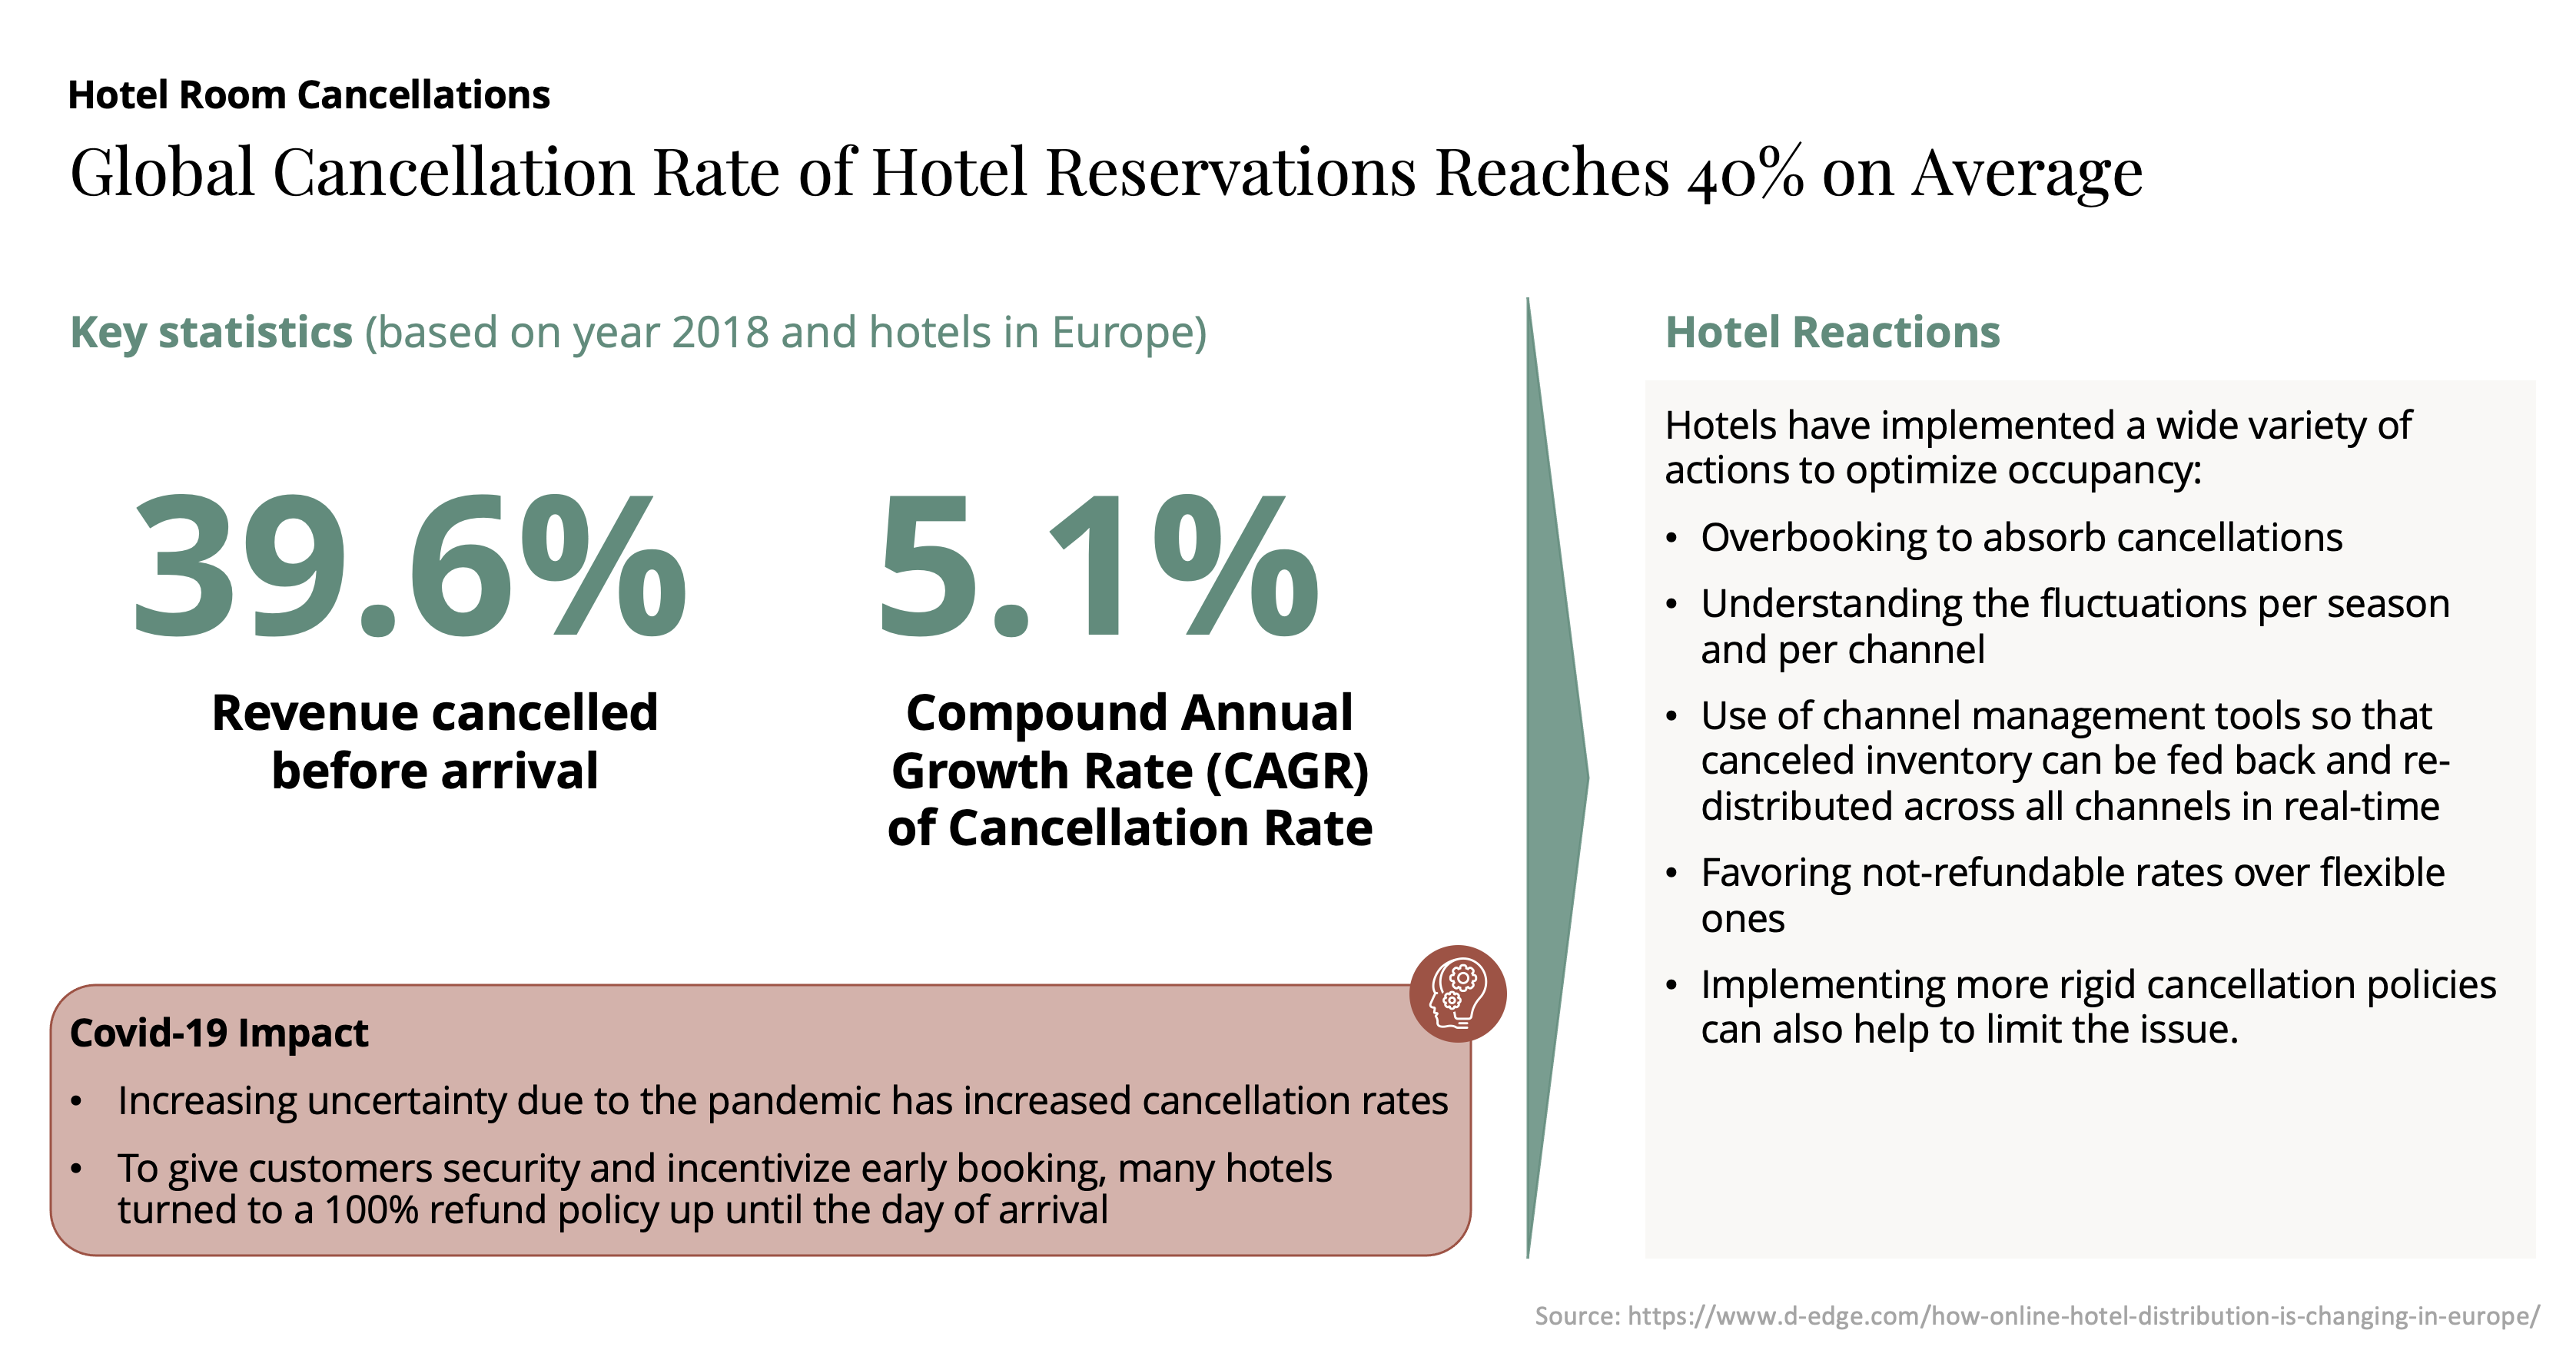

However, reducing the flexibility of bookings by dropping the user-friendly refund terms might put the hotel's competitiveness at risk. Therefore hotels might use a concept that is already prevailent in airlines: Overbooking the rooms they actually have and thereby absorbing the canellations (see abstraction below). By accepting more bookings than a hotel has rooms, it can make sure to be closer to full capacity utilization. However, this imposes the risk of not having rooms available and having to reject customers that have a reserved room. Therefore building a Machine Learning model that successfully predicts whether a customer is likely to cancel their booking is crucial in enabling the hotels to overbook the optimal number of rooms. That is the goal of this work.

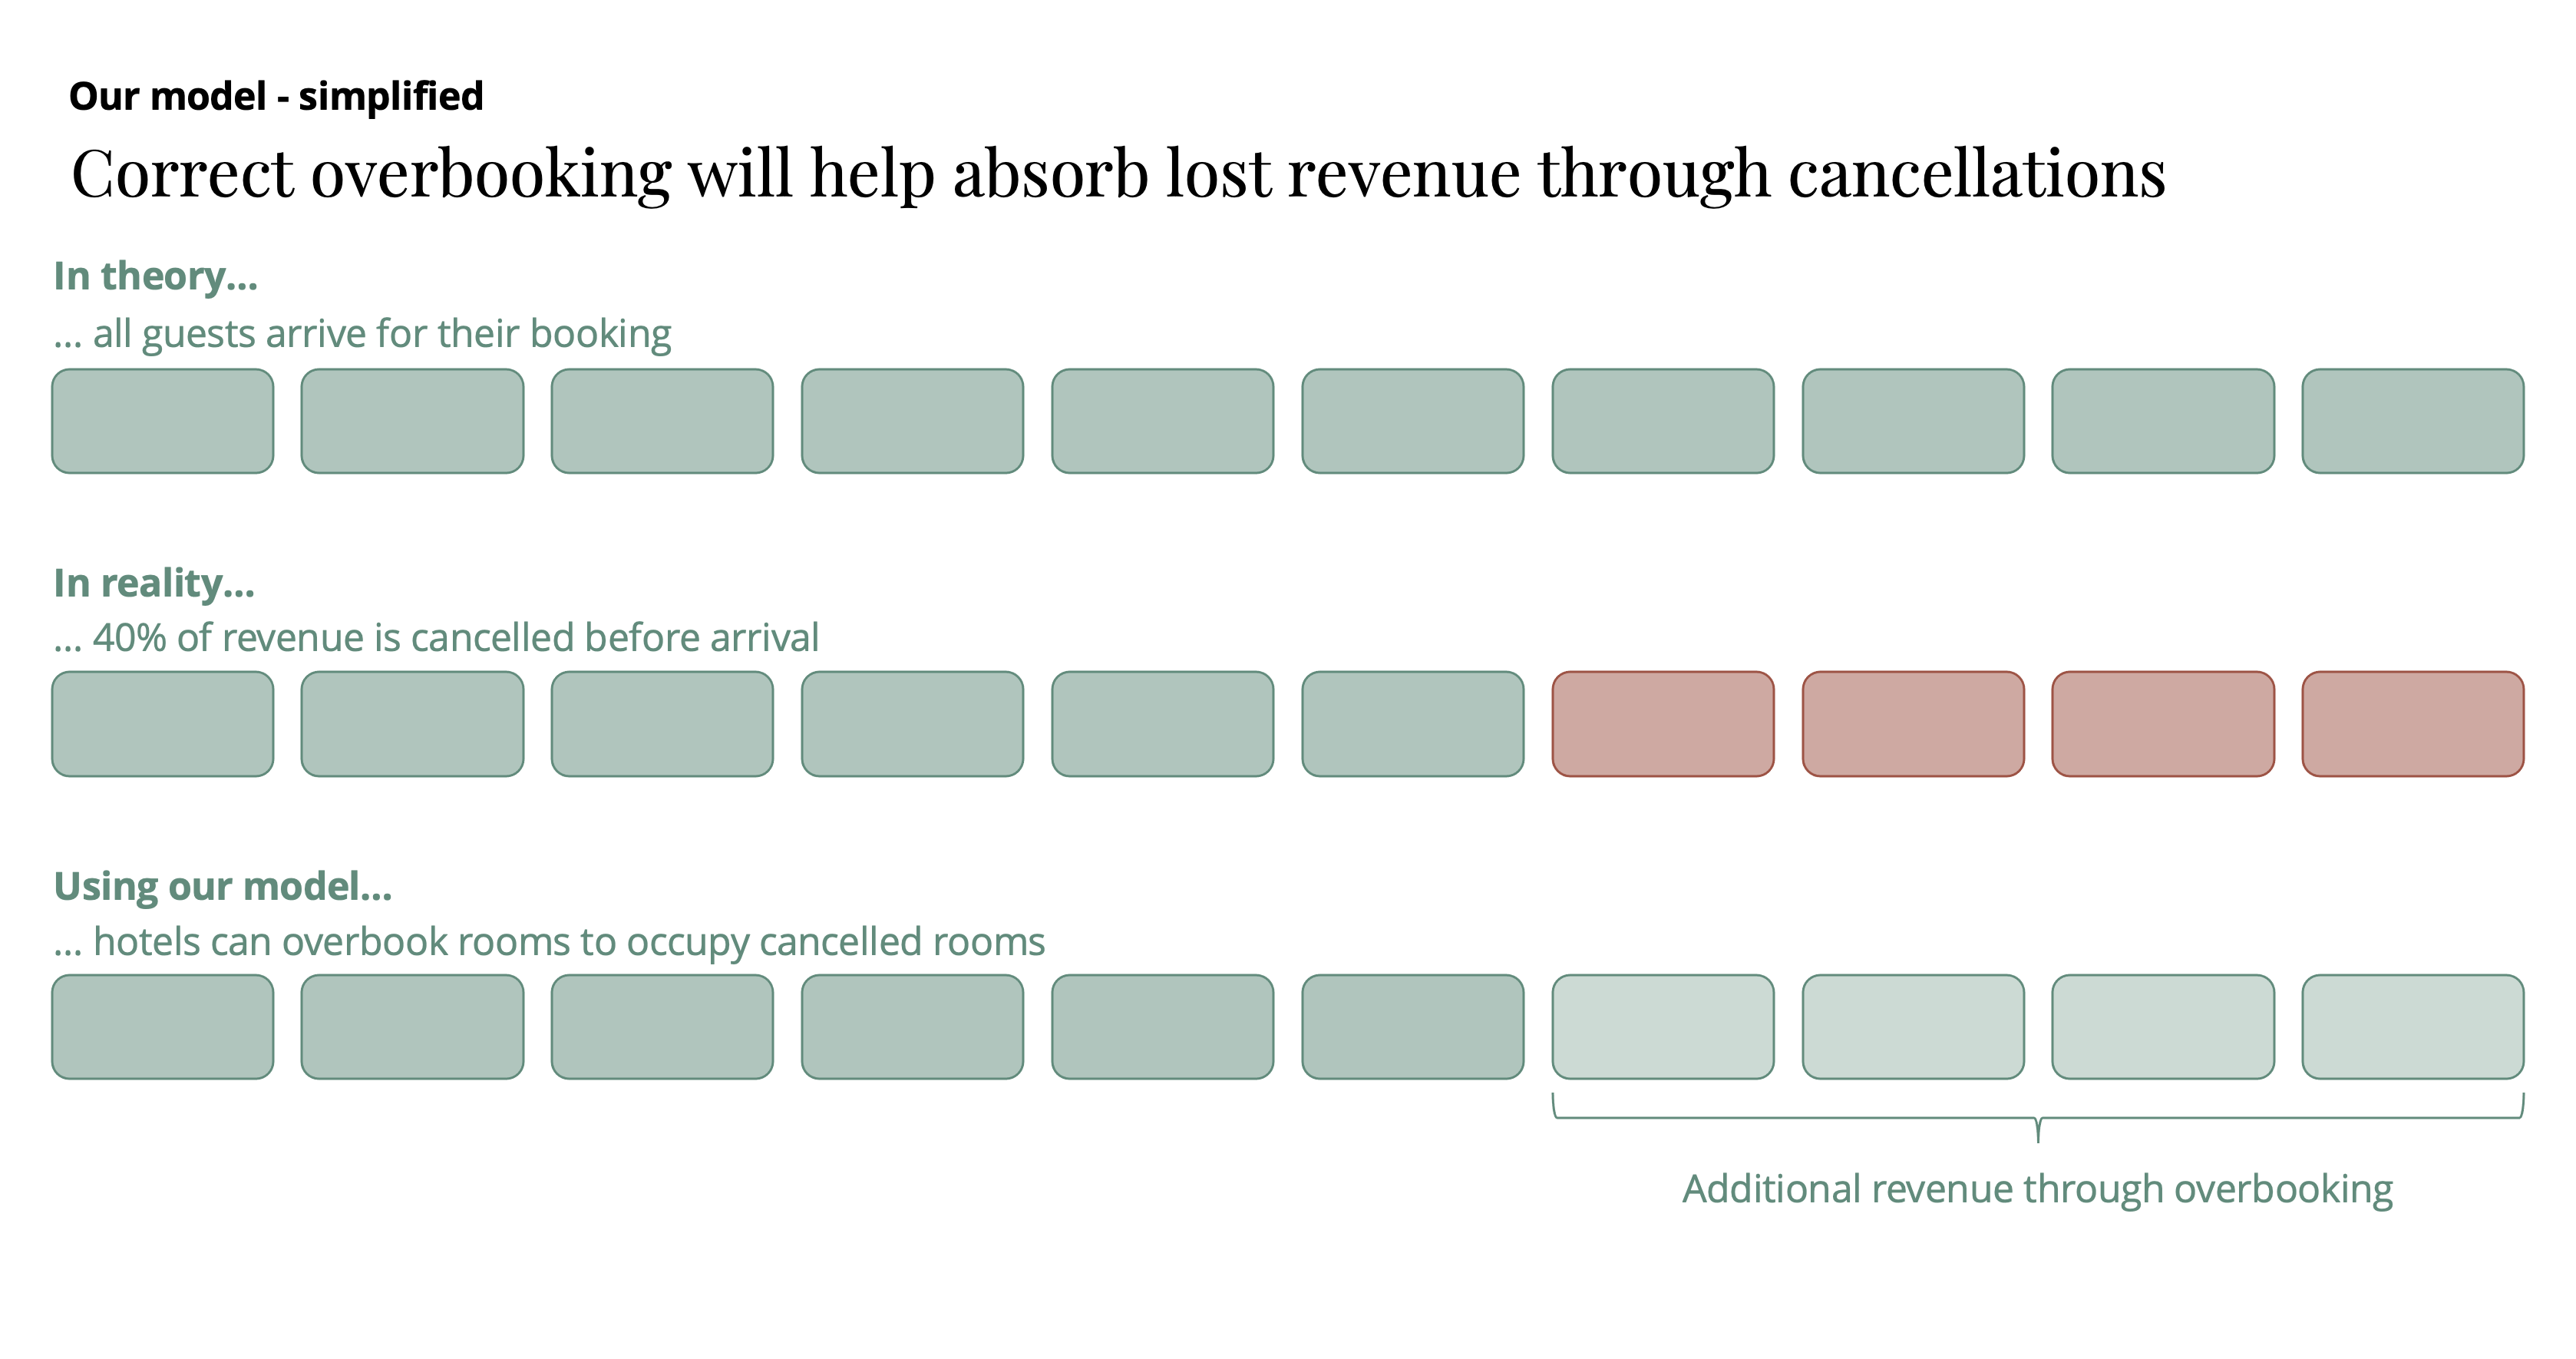

**After building our model, we successfully show that using our prediction algorithm, we can substantially improve the businesses revenue in the peak summer months. You can find the calculation [here](#businesscase).**

### Select a performance measure

In order to select an appropriate performance measure for our model, we first have to discuss the outcomes of each case:

- *Cost of False Positives:*
<br>In this case, **we predict that a customer cancels the room, but he actually doesn't cancel** and shows up
<br>The hotel runs into the risk of having too many customers show up and therfore not being able to serve all of them with rooms. This can have bad consequences and negatively impact the reputation of the hotel. Avoiding this scenario should be of high priority, however revenue is not directly effected.
<br>
<br>
- *Cost of False Negatives:*
<br>In this case, **we predict that a customer does not cancel the room, but he actually cancels** and does not show up
<br>As the model does not predict a cancellation, the hotel does not overbook this room. Therefore, this scenario may lead to unoptimized occupancy, especiallly if cancellations are short-term and the hotel is not able to react appropriately.
<br>
<br>
- *Gain of True Positives:*
<br>In this case, **we correctly predict that a customer cancels the room** and does not show up
<br>Through the use of overbooking, Hotels will be able to fill this room. The use of our model will therefore lead to additional revenue through better occupancy and not loose the money due to loose refund policies.
<br>
<br>
- *Gain of True Negatives:*
<br>In this case, **we correctly predict that a customer does not cancel the room** and shows up
<br>The customer behaves in line with expactations and will occupy the room. The use of our model neither increases nor decreases revenue.
<br>
<br>

In the case of hotel booking, false positives and false negatives balance each other out. Let's look at an example:
<br>We falsely predict that two customers cancel the room (while they actually don't), and at the same time falsely predict that three customers do not cancel the room (while they actually do). In this case, the hotel has three empty rooms, but is able to fill them with the two customers that show up even though they were predicted as canceled. Consequently, all customers can be served with a room and - while there is still unserved capacity - the hotel does not suffer a loss of reputation.

Based on the previous assessment, **we choose the F1-score as our performance measure**. The F1-score elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall. It is calculated as follows:

$$
\
F1=\frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\
$$

In our use-case, the errors caused by FPs and FNs are equally undesirable. In fact, we care about having them as equal as possible. We want Recall and Precision to be as high as possible, without focussing more on one of the measures. Therefore, we choose F1 as the appropriate measure of performance.

This performance measure is also dependent on which type of hotel is using the model. As we don't have an indication for the hotel in our case, we assume it is a mid-range establishment - neither budget, nor luxurious. However, for luxurious hotels, reputation is everything. Therefore, we woud recommend using Recall as the performance measure, because false positives, i.e. the risk of too many bookings, are more costly. In the opposite case, for budget hotels, it is more important to have better capacity than loose reputation by overbooking, we therefore recommend using Precision as performance measure in these cases.

### Check the assumptions

The result of this model is a classification of whether a room will be cancelled or not. We can use this information to precisely overbook certain rooms on a daily basis. This is based on the assumptions that this is the information that hotels need to use overbooking as a way to optimize capacity. Instead of simply forecasting cancellation rates for upcoming weeks (as it is current practice), our model predicts cancellations on a much more granular level. This makes it possible to react more fexible and on a per-room basis.

## 0. Imports & Data Access

In [1]:
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns
import numpy as np
import os
from datetime import timedelta

plt.style.use('seaborn')
seed = 42

In [2]:
exec_directory = os.getcwd()
main_directory = "Hotel-Booking-ML"
main_dir_path = exec_directory[:exec_directory.find(main_directory) + len(main_directory)]
raw_data_files_location = f"{main_dir_path}/data/raw"
df_all = pd.read_csv(f"{raw_data_files_location}/hotel_booking.csv")

As a first step we'll drop the columns 'reservation_status' and 'reservation_status_date' as they include information on our label. The value 'canceled' in 'reservation_status' indicates the same as 'is_canceled', this obviously information we don't need and shouldn't feed into the model.

In [3]:
df_all.drop(columns = ['reservation_status', 'reservation_status_date' ], inplace = True)

## 1. Data Exploration

In [4]:
df_all.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


<AxesSubplot:>

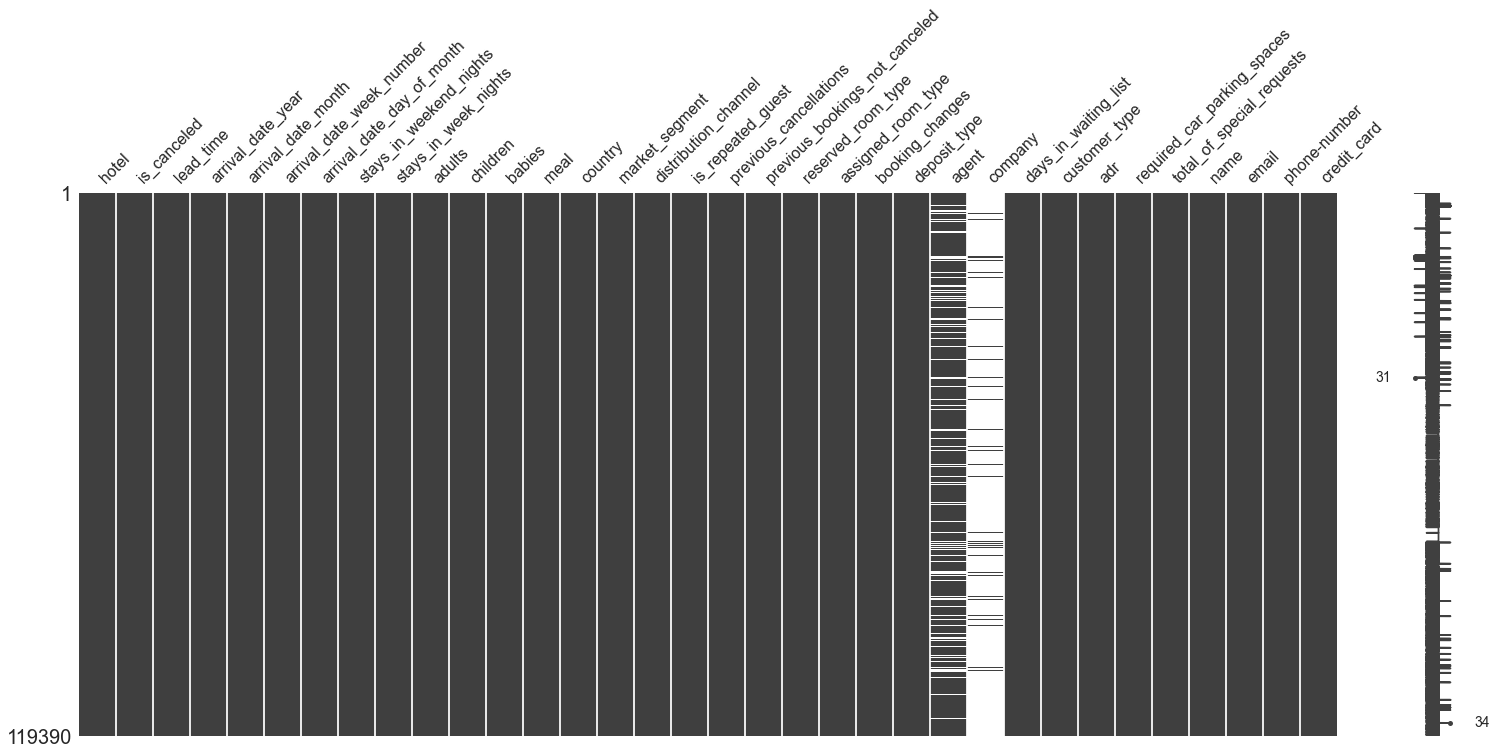

In [5]:
missingno.matrix(df_all)

#### Missing values

Luckily our dataset is complete for all features apart from agent and company. According to the data dictionary of the dataset these columns represent IDs of the agents and companies (in case of business travel) that made the bookings. Therefore it is likely that missing values do represent an information: a NA in 'company' indicates that the booking was not a business travel and a NA in 'agent' indicates that no agent was used for the booking, meaning that it was a direct booking.

Therefore we'll use OneHot encoding later on, to understand if there is a correlation between company, agent and our labels. 

#### Data transformation and aggregation. 

Before starting with the EDA we'll transform arrival and booking date to datetime format and transform the type of children in order to facilitate subsequent code operations. <br> We'll also aggregate data by calculating the number of total nights and retrieving the total number of guests. The aim of this is to reduce the number of features by aggregating redundant / similar information.

In [7]:
df_all.dropna(subset=['children'], inplace=True)
df_all['children'] = df_all['children'].astype(int)
df_all = df_all.astype({"country": str})

In [8]:
# Getting arrival and booking dates right
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                         'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_all['arrival_date_month'] = df_all['arrival_date_month'].apply(lambda m: month_mapping[m])
df_all['arrival_date'] = pd.to_datetime(dict(year = df_all.arrival_date_year, 
                                         month = df_all.arrival_date_month, 
                                         day = df_all.arrival_date_day_of_month))
df_all['booking_date'] = df_all.apply(lambda r: r['arrival_date'] - timedelta(days=r['lead_time']), axis=1)
df_all['booking_date_day_of_week'] = df_all['booking_date'].dt.weekday

# Number of Guests
df_all['guests'] = df_all['adults'] + df_all['children'] + df_all['babies']

# Length of stay
df_all['stay_total_nights'] = df_all['stays_in_weekend_nights'] + df_all['stays_in_week_nights']

# Is Family
df_all['is_family'] = np.where((df_all['children'] >= 1) | (df_all['babies'] >= 1), 1, 0)

# Assigned room type changed from booked room type
df_all['room_changed'] = np.where(df_all['reserved_room_type'] == df_all['assigned_room_type'], 0, 1)

As a second step, we split the data in a train and a test set before working on the data, because we don't want to influence our training and analysis by any information from the test set. We are using a 24 month period from 1st of July 2015 till 1st of July 2017 for training. Later, we will test our model's performance on a 2 month period including July and August 2017. This period is also a high demand period for hotels in which overbooking can be especially benefitial. 

In [9]:
import datetime
df = df_all[df_all['arrival_date'] < datetime.datetime(2017, 7, 1)]
df_test = df_all[df_all['arrival_date'] >= datetime.datetime(2017, 7, 1)]
print(df.shape)
print(df_test.shape)

(109148, 41)
(10238, 41)


## 2. Exploratory Data Analysis

We firstly split the EDA for categorical and numerical features, as we'll perform different analysis methods. 

There are two exceptions here: 
- We'll see binary variables (with 0 and 1) as a numerical feature, as it can be analyzed with the methdos we use for the 'true' numerical features.
- The 'hotel' feature discribes whether the data is for a 'City Hotel' or a 'Resort Hotel', it will be analyzed in numerical features as well. This is because we want to identify if it is worth to split the data we have according to the hotel and build separate models for each of the hotels. 

In [ ]:
df.head(5)

In [ ]:
categorical_features = [ 'meal', 'country', 'market_segment', 'distribution_channel', 
                         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
                         'customer_type']

df_num = df.drop(columns = categorical_features)

categorical_features.append('is_canceled')
df_cat = df[categorical_features]

### 2.1 Numerical features
#### 2.1.1 Correlations

First we'll take a lookt at collinearity in the data set, by pairplotting relevant features and calculating their correlations.

Please note that we are only using aggregated features here and not the features we calculated these aggregated ones on. For example, it wouldn't make sense to check for collinearity in guests with adults, children or babies as these variables are obviously correlated and won't be used side by side in the model. 

In [ ]:
sns.pairplot(data=df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']])
plt.show(sns)

In [ ]:
df_corr = pd.DataFrame(df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']].corr().unstack()).rename({0: 'correlation'}, axis=1)
df_corr[df_corr['correlation'] != 1].sort_values(by='correlation')

The highest correlation among our features is the correlation of ADR (revenue per day) with the number of guests, this follows the logic that with the more people you stay in a hotel, the more you'll spend. When building the model we'll take a closer look if this becomes a problem. For the other features the correlations are really small and therefore no worry.  

Now, lets get the correlations of the **label** with the features, separately for the resort and city hotel to find out if they differ substiantially. This will be interesting when deciding whether to build separate models or not. 

In [ ]:
correlations_all = df_num.corr()['is_canceled'].sort_values(ascending=False)
correlations_city = df_num[df_num['hotel'] == 'City Hotel'].corr()['is_canceled']
correlations_resort = df_num[df_num['hotel'] == 'Resort Hotel'].corr()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

This already gives a good indication, but let's plot the data to make the difference easier to understand.

In [ ]:
correlations_plot_df = pd.melt(correlations_df.drop('is_canceled'), ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)
plt.title('Correlations by hotels')
plt.show()

This bar-chart shows that lead_time, previous_canellations, total_of_special_requests, required_car_parking_space and booking_changes have a correlation that is higher than 0.1 (in absolute terms). These are important candidates for our ML model later on. Additionally, the chart shows that for some features the correlation heavily depends on the kind of hotel we are looking at: For example, the number of total special requests is highly correlated with the cancellations at the city hotel, but not so much at the resort hotel. 

Based on this observation we will try out when building our first models, wether separate models or a joint model for both hotels performs better. 

As booking changes cumulates over time the dataset doesn't include the information when the last change was made, we will not use it in our model. By this we prevent information that might have appeared just days before the arrival from influencing our model whith wich we want to predict cancelations at least 7 days before (the exact number will be deiced later on). 

Some numeric variables can also be used in binary form, which could benefit the model's performance. In order to find out which option should be picked, we will look at the correlations with the target variable is_canceled. Let's first look at total_of_special requests.

In [ ]:
df_corrcheck = df
df_corrcheck['any_requests'] = df_corrcheck.total_of_special_requests.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_requests', 'total_of_special_requests']].corr()

As the binary variable any_requests is more correlated with is_canceled, we will choose this option later on. Now let's inspect previous_canellations.

In [ ]:
df_corrcheck['any_cancelations'] = df_corrcheck.previous_cancellations.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_cancelations', 'previous_cancellations']].corr()

This correlation is significantly higher in binary form. We will therefore use it in our model. Next up: required_car_parking_spaces.

In [ ]:
df_corrcheck['any_parking'] = df_corrcheck.required_car_parking_spaces.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_parking', 'required_car_parking_spaces']].corr()

There is only little difference between the binary and the numeric column. We will go for the binary variable to keep the model simpler.

#### 2.1.2 Frequency Distributions

In [ ]:
df_num.hist(bins=50, figsize=(25,15))
plt.show()

In [ ]:
sns.histplot(df['booking_date_day_of_week'])
plt.show(sns)

In [ ]:
sns.histplot(df['hotel'])
plt.show(sns)

In [ ]:
sns.histplot(df['lead_time'])
plt.show(sns)

### 2.2 Categorical variables

#### 2.2.1 Understanding the categories

Here we'll use df_cat, with all categorical features we have identified perviously. 

In [ ]:
df_cat.columns

'Company' and 'agent' are columns with ids. Let's look at the values in the other ("true") categorical variables to get a feeling for what they are. 

In [ ]:
df_cat[['meal']].value_counts(normalize = True)

In [ ]:
df_cat[['country']].value_counts(normalize = True).head(10)

In [ ]:
df_cat[['market_segment']].value_counts(normalize = True)

In [ ]:
df_cat[['distribution_channel']].value_counts(normalize = True)

In [ ]:
df_cat[['reserved_room_type']].value_counts(normalize = True)

In [ ]:
df_cat[['assigned_room_type']].value_counts(normalize = True)

In [ ]:
df_cat[['deposit_type']].value_counts(normalize = True)

In [ ]:
df_cat[['customer_type']].value_counts(normalize = True)

Especially, the deposit type seems likely to have a high explanatory power. If you have made no deposit you are much more likely to cancel a booking than when you made a non-refundable deposit, right?

#### 2.2.2 Correlations of categorical variables with cancellations

Let's OneHot Encode the categories and IDs (for agent and company) in the next step and get their correlations with the cancellations. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False)
df_cat = df_cat.sort_index().reset_index(drop = True)
df_cat_trans = pd.DataFrame(data = onehot.fit_transform(df_cat.drop(columns = 'is_canceled')),
                                columns = onehot.get_feature_names_out())

In [ ]:
df_cat_trans = pd.concat([df_cat.is_canceled, df_cat_trans], axis = 1 )


Now we'll use this transformed dataframe of our categorical variables and find out how correlated they are with 'is_canceled'.

Watch out, the next cell takes quite a while to compute. 

In [ ]:
df_cat_corr = df_cat_trans.corr()
df_cat_corr = df_cat_corr['is_canceled']

In [ ]:
df_cat_corr.sort_values()

This is gives a dataframe of **xxxx** correlations with the label. Very likely, most of them will have a very low correlation with the label. Therefore, let's only look at the ones with a correlation of more than 0.05 (positive or negative).

In [ ]:
df_cat_corr_red = pd.DataFrame(df_cat_corr).rename({'is_canceled' : 'correlation'}, axis = 1)
df_cat_corr_red = df_cat_corr_red[(df_cat_corr_red['correlation'] >= 0.1 ) | (df_cat_corr_red['correlation'] <= -0.1) ]
df_cat_corr_red.sort_values(by = 'correlation')[:-1].plot(kind = 'bar')
plt.show()

This gives us a good indication, that especially x2 (= 'deposit_type') is likely to have a high explanatory power. But also x1 = ('Coutnry') equalling to Portugal, x2 (= 'market_segment') equalling to Groups can be important when building the model.

### 2.3 Time Series Analysis
In this section we are looking for underlying seasonality in the given cancelations and bookings.

In [ ]:
df_resort = df[df["hotel"] == "Resort Hotel"]
df_city = df[df["hotel"] == "City Hotel"]

#Get data for Resort Hotel
df_timeseries_r = pd.DataFrame(df_resort.groupby("arrival_date_month").size())
df_timeseries_r["Cancelations"] = df_resort.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_r.columns = ['Arrivals', 'Cancelations']
df_timeseries_r["Cancelation_Share"] = df_timeseries_r["Cancelations"]/df_timeseries_r["Arrivals"]

#Get data for City Hotel
df_timeseries_c = pd.DataFrame(df_city.groupby("arrival_date_month").size())
df_timeseries_c["Cancelations"] = df_city.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_c.columns = ['Arrivals', 'Cancelations']
df_timeseries_c["Cancelation_Share"] = df_timeseries_c["Cancelations"]/df_timeseries_c["Arrivals"]

#Plot linechart
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Reservations")
ax1.plot(
    df_timeseries_r["Arrivals"],
    color="red",
    label="Arrivals (Resort)"
)

ax1.plot(
    df_timeseries_c["Arrivals"],
    color="green",
    label="Arrivals (City)"
)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("Rate of Cancelations")
ax2.plot(
    df_timeseries_r["Cancelation_Share"],
    color="red",
    linestyle="dashed",
    label="Rate of Cancelations (Resort)",
)

ax2.plot(
    df_timeseries_c["Cancelation_Share"],
    color="green",
    linestyle="dashed",
    label="Rate of Cancelations (City)",
)

fig.legend(loc = 2, borderaxespad=9)

Based on this plot, we can draw several conclusions:

- Bookings and cancelation-rate differs greatly between Resort and City Hotels. With City Hotels experiencing more bookings but also more cancellations.
- Cancellation rate follows the same patten as the number of bookings.
- Bookings and cancellations follow a seasonal pattern.

## 3. Preliminary Model Selection
Before going deeper into feature selection, we want to understand which model is the most promising for our task. For this model, more sophisticated feature selection will be conducted. We will test 5 different models:
1. Logistic Regression
2. Random Forest Classifier
3. XGBoost Classifier
4. Support Vector Machine
5. Artificial Neural Network

### 3.1 Feature Selection Pipeline
Before testing the models, we need to build a pipeline in which all features get transformed into a format the models can best work with. Numerical features are standard scaled. For the categorical features, dimensions with less than 5% occurrences are aggregated in a 'other' category. Subsequently, categories are one-hot-encoded. The features *booking_changes* and *deposit_type* are excluded from the feature selection due to their inadequateness depicted in *2*.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Binarizer, FunctionTransformer, StandardScaler, OneHotEncoder

num_features = ['lead_time', 'adr', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'stays_in_weekend_nights', 'stay_total_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'total_of_special_requests', 'room_changed']

cat_features = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type']

class replace_other(TransformerMixin):
    """Replaces every value that accounts for less than 5% of the count of all unique
    values in the column with 'Other'"""

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, df):
        for col in df.columns:
            counts = df[col].value_counts(normalize=True)
            irrelevant = counts[counts < 0.05].index.tolist()
            df[col] = df[col].apply(lambda v: 'Other' if v in irrelevant else v)
        return df

    def get_feature_names_out(self, col_names):
        return col_names

cat_selection_pipeline = Pipeline(steps=[
    ('replace_other', replace_other()),
    ('encoder', OneHotEncoder(sparse=False))
])

feature_selection_pipeline = ColumnTransformer(transformers=[
    ('numeric', StandardScaler(), num_features),
    ('categorical', cat_selection_pipeline, cat_features)
])

In [18]:
feature_selection_df = pd.DataFrame(data=feature_selection_pipeline.fit_transform(df), columns=feature_selection_pipeline.get_feature_names_out())
feature_selection_test_df = pd.DataFrame(data=feature_selection_pipeline.transform(df_test), columns=feature_selection_pipeline.get_feature_names_out())
feature_selection_df

,numeric__lead_time,numeric__adr,numeric__arrival_date_month,numeric__arrival_date_week_number,numeric__arrival_date_day_of_month,numeric__stays_in_week_nights,numeric__stays_in_weekend_nights,numeric__stay_total_nights,numeric__adults,numeric__children,...,categorical__reserved_room_type_D,categorical__reserved_room_type_E,categorical__reserved_room_type_Other,categorical__assigned_room_type_A,categorical__assigned_room_type_D,categorical__assigned_room_type_E,categorical__assigned_room_type_Other,categorical__customer_type_Other,categorical__customer_type_Transient,categorical__customer_type_Transient-Party
0,2.305699,-2.063032,0.166305,0.011548,-1.687373,-1.298731,-0.913466,-1.326328,0.268544,-0.244869,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,6.070802,-2.063032,0.166305,0.011548,-1.687373,-1.298731,-0.913466,-1.326328,0.268544,-0.244869,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.887489,-0.468094,0.166305,0.011548,-1.687373,-0.772025,-0.913466,-0.933439,-1.436477,-0.244869,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.830298,-0.468094,0.166305,0.011548,-1.687373,-0.772025,-0.913466,-0.933439,-1.436477,-0.244869,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.820766,0.021020,0.166305,0.011548,-1.687373,-0.245320,-0.913466,-0.540549,0.268544,-0.244869,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109143,-0.544341,1.231684,-0.144738,-0.059059,1.504740,1.334798,1.094004,1.423899,1.973564,-0.244869,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
109144,1.381104,-0.108063,-0.144738,-0.059059,1.504740,1.334798,1.094004,1.423899,0.268544,-0.244869,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
109145,0.713871,-0.108063,-0.144738,-0.059059,1.504740,1.334798,1.094004,1.423899,0.268544,-0.244869,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
109146,0.799658,0.244524,-0.144738,-0.059059,1.618744,1.334798,1.094004,1.423899,0.268544,-0.244869,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### 3.2 Recursive Feature Elimination
As we can see, the resulting number of features is 49. This number might be too high for some models. In order to best compare them, we'll eliminate the unimportant features so that for each model only the top 15 are left. An exception form the SVM and ANN. Here, since feature reduction is less straight forward than for the other models, we take the top 15 features that appear most times within the other models.

In [16]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from typing import Dict, List

top_features: Dict[str, List[str]] = {}

estimators: Dict[str, dict] = {
    'Logistic Regression': {'model': LogisticRegression(max_iter=300),
                            'rfe_possible': True},
    'Random Forest Classifier': {'model': RandomForestClassifier(),
                                 'rfe_possible': True},
    'XGBoost Classifier': {'model': XGBClassifier(objective='binary:logistic', use_label_encoder=False),
                           'rfe_possible': True},
    'SVM': {'model': SVC(probability=True),
            'rfe_possible': False}
}  # Artificial Neural Network will be considered separately under 3.3.2

for estimator in estimators:
    if not estimators[estimator]['rfe_possible']:
        continue
    else:
        estimator_model = estimators[estimator]['model']
        selector = RFE(estimator_model, n_features_to_select=15, step=10)
        selector.fit(feature_selection_df, df['is_canceled'])
        top_features[estimator] = feature_selection_df.columns[selector.support_].tolist()

all_top_features = [e for l in [top_features[estimator] for estimator in top_features] for e in l]
top_features['Highest Frequency'] = pd.Series(all_top_features).value_counts().iloc[:15].index.tolist()
top_features

/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

[11:53:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:53:52] WARNING: /Users/runner/miniforge3/cond

{'Logistic Regression': ['numeric__lead_time',
  'numeric__arrival_date_month',
  'numeric__arrival_date_week_number',
  'numeric__previous_cancellations',
  'numeric__previous_bookings_not_canceled',
  'numeric__total_of_special_requests',
  'numeric__room_changed',
  'categorical__country_DEU',
  'categorical__country_PRT',
  'categorical__market_segment_Direct',
  'categorical__market_segment_Groups',
  'categorical__market_segment_Online TA',
  'categorical__distribution_channel_Other',
  'categorical__reserved_room_type_Other',
  'categorical__customer_type_Transient'],
 'Random Forest Classifier': ['numeric__lead_time',
  'numeric__adr',
  'numeric__arrival_date_month',
  'numeric__arrival_date_week_number',
  'numeric__arrival_date_day_of_month',
  'numeric__stays_in_week_nights',
  'numeric__stay_total_nights',
  'numeric__previous_cancellations',
  'numeric__total_of_special_requests',
  'numeric__room_changed',
  'categorical__country_PRT',
  'categorical__market_segment_Grou

### 3.3 Model Performances
With only the top 15 features left, we can now better compare the performances of the different models.

In order to compare model performances, we define some standard functions we can apply. These functions will be used throughout the remainder of the notebook.

#### 3.3.1 Logistic Regression, Random Forest, GXBoost & SVM

In [19]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
fitted_models = []  # used for roc curve plot later
X_test_sets = [] # used for roc curve plot later

for model_name in estimators:
    """
    if model == ann:
        pred_proba = ann.predict(X_test.astype('float32'))[:,1]
        model_pred = np.where(pred_proba > 0.5, 1,0)

    else:
        model_pred = model.predict(X_test)
    """
    model_features = top_features[model_name] if estimators[model_name]['rfe_possible'] else top_features['Highest Frequency']
    model = estimators[model_name]['model']
    X_train_model = feature_selection_df[model_features]
    y_train_model = df['is_canceled']
    X_test_model = feature_selection_test_df[model_features]
    y_test_model = df_test['is_canceled']

    model.fit(X_train_model, y_train_model)
    model_pred = model.predict(X_test_model)

    accuracy = round(accuracy_score(y_test_model, model_pred), 4)
    recall = round(recall_score(y_test_model, model_pred), 4)
    precision = round(precision_score(y_test_model, model_pred), 4)
    f1 = round(f1_score(y_test_model, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model_name])
    comparison_df = comparison_df.join(model_statistics)

    fitted_models.append(model)
    X_test_sets.append(X_test_model)
comparison_df

/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:57:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Logistic Regression,Random Forest Classifier,XGBoost Classifier,SVM
Accuracy,0.7374,0.7114,0.7372,0.7304
Precision,0.6766,0.6683,0.6710,0.6813
Recall,0.5600,0.4416,0.5726,0.5142
F1 Score,0.6128,0.5318,0.6179,0.5861


#### 3.3.2 Artificial Neural Network
In addition to "normal" machine learning models, we also want to try an Artificial Neural Network. Since the process of training and predicting is different, in the following we will compute relevant metrics and append them to the previously computed.

In [20]:
import tensorflow as tf
import tensorflow.keras as keras

# Building the ANN
model = keras.Sequential()
model.add(keras.Input(shape=(15,)))
model.add(keras.layers.Dense(units=260, activation='relu'))
model.add(keras.layers.Dense(units=140, activation='relu'))
model.add(keras.layers.Dense(2, activation="softmax"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
            loss = keras.losses.SparseCategoricalCrossentropy(),
            metrics = ['accuracy'])

# Retrieving the features, based on most important features from RFE of all other models
X_train_model = feature_selection_df[top_features['Highest Frequency']]
y_train_model = df['is_canceled']
X_test_model = feature_selection_test_df[top_features['Highest Frequency']]
y_test_model = df_test['is_canceled']

# Training the model
history = model.fit(X_train_model.astype('float32'),
                    y_train_model.astype('float32'),
                    epochs=20,
                    validation_split=0.2,
                    batch_size = 128)

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1


2022-05-06 12:18:10.357389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-06 12:18:10.357528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-06 12:18:10.989125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-06 12:18:10.992432: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `outpu

Epoch 1/20
683/683 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.8207

/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2022-05-06 12:18:17.092077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


683/683 [==============================] - 7s 6ms/step - loss: 0.3815 - accuracy: 0.8207 - val_loss: 0.6277 - val_accuracy: 0.6548
Epoch 2/20
683/683 [==============================] - 3s 5ms/step - loss: 0.3477 - accuracy: 0.8374 - val_loss: 0.4744 - val_accuracy: 0.7711
Epoch 3/20
683/683 [==============================] - 3s 5ms/step - loss: 0.3397 - accuracy: 0.8416 - val_loss: 0.5893 - val_accuracy: 0.6995
Epoch 4/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3349 - accuracy: 0.8446 - val_loss: 0.5858 - val_accuracy: 0.6956
Epoch 5/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3301 - accuracy: 0.8465 - val_loss: 0.5848 - val_accuracy: 0.6931
Epoch 6/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3259 - accuracy: 0.8495 - val_loss: 0.6403 - val_accuracy: 0.6579
Epoch 7/20
683/683 [==============================] - 4s 5ms/step - loss: 0.3227 - accuracy: 0.8515 - val_loss: 0.4936 - val_accuracy: 0.7462
Epoch 8/20
683/68

In [21]:
# Using the ANN to predict labels
pred_proba = model.predict(X_test_model.astype('float32'))[:,1]
model_pred = np.where(pred_proba > 0.5, 1,0)

# Calculating the relevant metrics
accuracy = round(accuracy_score(y_test_model, model_pred), 4)
recall = round(recall_score(y_test_model, model_pred), 4)
precision = round(precision_score(y_test_model, model_pred), 4)
f1 = round(f1_score(y_test_model, model_pred), 4)

# Adding the results to the previously defined dfs / lists from the previous models
model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=["Artififical Neural Network"])
comparison_df = comparison_df.join(model_statistics)
fitted_models.append(model)
X_test_sets.append(X_test_model)
comparison_df

2022-05-06 12:19:44.168669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,Logistic Regression,Random Forest Classifier,XGBoost Classifier,SVM,Artififical Neural Network
Accuracy,0.7374,0.7114,0.7372,0.7304,0.7044
Precision,0.6766,0.6683,0.6710,0.6813,0.6354
Recall,0.5600,0.4416,0.5726,0.5142,0.4779
F1 Score,0.6128,0.5318,0.6179,0.5861,0.5455


### 3.4 Model Comparison
First, we look at the scores obtained:

In [23]:
comparison_df

,Logistic Regression,Random Forest Classifier,XGBoost Classifier,SVM,Artififical Neural Network
Accuracy,0.7374,0.7114,0.7372,0.7304,0.7044
Precision,0.6766,0.6683,0.6710,0.6813,0.6354
Recall,0.5600,0.4416,0.5726,0.5142,0.4779
F1 Score,0.6128,0.5318,0.6179,0.5861,0.5455


We can see that the Random Forest model is the best model in for every metric except for recall (Logistic Regression performs best).

/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/patrickgundlach/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
2022-05-06 12:24:07.831073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


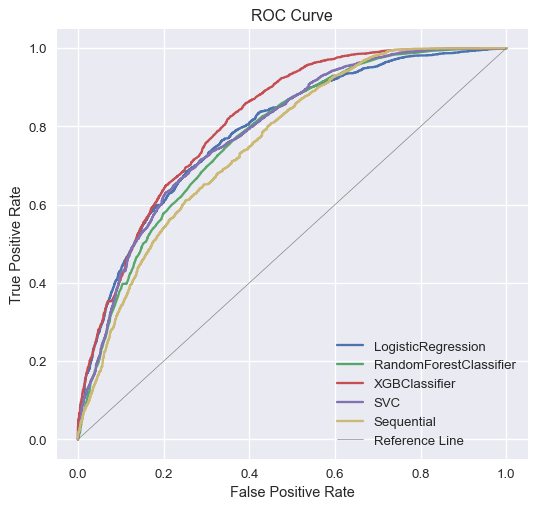

In [29]:
from typing import Union

def get_roc_curve_multiple(models, X_test_in: Union[pd.DataFrame, List[pd.DataFrame]], y_true: pd.Series):
    plt.figure(figsize=(6.4, 6), dpi=95)

    #create ROC curve fpr each model

    for i, model in enumerate(models):
        X_test = X_test_in[i] if isinstance(X_test_in, list) else X_test_in
        if False: #model == ann:
            y_pred_proba = ann.predict(X_test.astype('float32'))[:,1]
        else:
            y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)
        plt.plot(fpr, tpr, label=model.__class__.__name__)

    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey', label='Reference Line')  # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.title('ROC Curve')

get_roc_curve_multiple(fitted_models, X_test_sets, df_test['is_canceled'])

In [30]:
selector = RFE(RandomForestClassifier(), n_features_to_select=15, step=10)
feat_rank_df = pd.DataFrame(data=selector.ranking_, index=feature_selection_df.columns, columns=['rank']).sort_values('rank', ascending=True)
feat_rank_df

AttributeError: 'RFE' object has no attribute 'ranking_'

Let's look at the relative importance of the remaining 15 features in a Random Forest:

In [434]:
remaining_features = feature_selection_df.columns[selector.support_]
feature_selection_remainder_df = feature_selection_df[remaining_features]
rf_feature_selection = RandomForestClassifier()
rf_feature_selection.fit(feature_selection_remainder_df, df['is_canceled'])
importances_df = pd.DataFrame(data=rf_feature_selection.feature_importances_, index=remaining_features, columns=['Importance']).sort_values('Importance', ascending=False)
importances_df

,Importance
numeric__lead_time,0.203632
numeric__adr,0.137911
categorical__country_PRT,0.104149
numeric__arrival_date_day_of_month,0.083421
numeric__arrival_date_week_number,0.071397
numeric__total_of_special_requests,0.069940
categorical__market_segment_Online TA,0.050861
numeric__room_changed,0.042354
numeric__stay_total_nights,0.041968
numeric__previous_cancellations,0.039718


<AxesSubplot:>

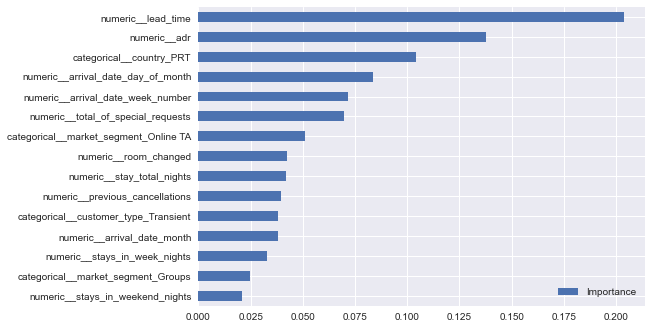

In [435]:
importances_df.sort_values('Importance', ascending=True).plot.barh()

In [437]:
df['market_segment'].value_counts(normalize=True)

Online TA        0.473667
Offline TA/TO    0.203208
Groups           0.165421
Direct           0.105017
Corporate        0.044269
Complementary    0.006418
Aviation         0.002000
Name: market_segment, dtype: float64

The two clearly most important features are the lead time and the average daily revenue (adr). The remaining features all have a pretty low, but balanced, importance that remains above the 2% mark.

## 4. Model Tuning
### 4.1 Preprocessing Pipeline
For the features chosen in 3.3, a preprocessing pipeline is built in which features get standardized or binarized.

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Binarizer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

In [ ]:
#Define categories of attributes
num_attribs = ["lead_time", "adr", "stay_total_nights"]
num_attribs_discr = ["arrival_date_day_of_month", "arrival_date_month", "arrival_date_week_number", "room_changed"]
num_attribs_bin = ["total_of_special_requests", "previous_cancellations"]
cat_attribs_bin = [
    # (column, true value)
    ("country", "PRT"),
    ("market_segment", "Online TA"),
    ("market_segment", "Groups"),
    ("customer_type", "Transient")
]

# Create a class to select specified columns from DataFrame
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# Define function for one-vs-all binary transformation of categorical variables
def binary_tansformer_cat(arr, true_vals):
    # order of true_vals needs to be equivalent to corresponding column names in cat_attribs_bin
    for i, true_val in enumerate(true_vals):
        arr[:, i] = np.where(arr[:, i] == true_val, 1, 0)
    return arr

num_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs)),
        ('scaler', StandardScaler())
    ])

num_discrete_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs_discr))
    ]
)

num_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs_bin)),
        ('binarizer', Binarizer())
    ])

cat_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector([e[0] for e in cat_attribs_bin])),
        ('binarizer_cat', FunctionTransformer(binary_tansformer_cat, kw_args={'true_vals': [e[1] for e in cat_attribs_bin]}))
    ])

preprocessor = FeatureUnion(
    transformer_list = [
        ('num_pipeline', num_pipeline),
        ("num_discrete_pipeline", num_discrete_pipeline),
        ("num_binary_pipeline", num_binary_pipeline),
        ("cat_binary_pipeline", cat_binary_pipeline),
#        ("cat_pipeline", cat_pipeline)
    ])
preprocessor

### 4.2 Creation of X_train, y_train, X_test, y_test
For the subsequent modeling, we need uniform datasets for training and testing data. Therefore, we split the existent 'df' (training data), 'df_test' (testing data) into X (features) and y (labels). The features are passed through the preprocessing pipeline.

In [ ]:
set_config(display='text')
X_train = preprocessor.fit_transform(df)
y_train = df['is_canceled']
X_test = preprocessor.fit_transform(df_test)
y_test = df_test['is_canceled']

### 4.3 Standardized Model Evaluation
We define several functions to evaluate a model. The aim is to have standardized functions to compare the various models on.

In [28]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, roc_curve
import seaborn as sns

def get_cnf_matrix(y_true, y_pred):
    """
    This function receives a true y and a predicted y array. It plots a confusion matrix as sns.heatmap.
    
    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values. 
        y_pred:
            numpy array or pandas Series / DF of predicted y values. 
    """

    cnf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix

    class_names=[0,1]
    fig, ax = plt.subplots(figsize=(3.5,2.8), dpi=105)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix),
                annot=True,
                cmap="YlGnBu" ,
                fmt='g',
                )#annot_kws={"size": 15, "weight": "bold"})
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion Matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def get_metrics(y_true, y_pred):
    """
    This function receives a true y and a predicted y array. It prints Recall, Precision and Accuracy.
    
    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values. 
        y_pred:
            numpy array or pandas Series / DF of predicted y values. 
    """
    print("Recall:", round(recall_score(y_true, y_pred),4))
    print("Precision:", round(precision_score(y_true, y_pred),4))
    print("Accuracy:", round(accuracy_score(y_true, y_pred),4))
    print("F1 Score:", round(f1_score(y_true, y_pred),4))


def get_roc_curve(y_true, pred_proba):
    y_pred_proba = pred_proba[::,1]
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)

    #create ROC curve
    plt.figure(figsize=(4.3, 4), dpi=95)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey') # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')

def get_roc_curve_ann(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)

    #create ROC curve
    plt.figure(figsize=(4.3, 4), dpi=95)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey') # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')

def get_roc_curve_multiple(models, X_test, y_true):
    plt.figure(figsize=(6.4, 6), dpi=95)

    #create ROC curve fpr each model
    for model in models:
        if model == ann:
            y_pred_proba = ann.predict(X_test.astype('float32'))[:,1]
        else:
            y_pred_proba = model.predict_proba(X_test)[::,1]
        fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)
        plt.plot(fpr, tpr, label=model.__class__.__name__)

    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey', label='Reference Line')  # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.title('ROC Curve')

### 4.4 Models

In the following we will test different models for the previously selected features. We will not be evaluating them based on a single business criterium/metric right now. Instead, we will use the overall confusion matrix, precision, recall and accuracy to get a feeling for the fit of a model to our problem. 

#### 4.4.1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

log_reg = LogisticRegression(class_weight = 'balanced',
                             random_state = seed)

params = {'C': [0.001, 0.01, 0.1, 1],
          'solver' : ['liblinear', 'saga'],
          'penalty': ['l1', 'l2']}

RSCV = RandomizedSearchCV(log_reg,
                          params,
                          cv = 5,
                          scoring = 'accuracy',
                          return_train_score = True,
                          n_jobs = -1,
                          #n_iter = 20,
                          random_state=42)


search = RSCV.fit(X_train, y_train)
results = pd.DataFrame(search.cv_results_)

In [ ]:
best_log_reg = search.best_estimator_
best_log_reg

In [ ]:
pred = best_log_reg.predict(X_test)
pred_proba = best_log_reg.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

#### 4.4.2 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=500,
                                       random_state=42)
param_grid = {'max_depth': [25],  #[15, 25],
              'min_samples_split': [2],  #[2,5],
              'min_samples_leaf': [1],  #[1,3]
              'max_features': ['auto']}  #, 15, 12, 9]}
gscv_rf = GridSearchCV(random_forest,
                       param_grid=param_grid,
                       cv=5,
                       n_jobs=-1)

gscv_rf.fit(X_train, y_train)

In [ ]:
best_rf = gscv_rf.best_estimator_
best_rf

In [ ]:
pred = best_rf.predict(X_test)
pred_proba = best_rf.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

In [ ]:
best_rf.feature_importances_

#### 4.4.3 XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [5,7], 'min_child_weight': [1,3]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 500, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                             cv_params,
                             scoring = 'accuracy',
                             cv = 5,
                             n_jobs = -1)
optimized_GBM.fit(X_train, y_train)

In [ ]:
best_xgb = optimized_GBM.best_estimator_

In [ ]:
pred = best_xgb.predict(X_test)
pred_proba = best_xgb.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

#### 4.4.X Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('lr', best_log_reg), ('rf', best_rf), ('xgb', best_xgb)],
    voting='soft')
voting_clf.fit(X_train, y_train)

In [ ]:
pred = voting_clf.predict(X_test)
pred_proba = voting_clf.predict_proba(X_test)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve(y_test, pred_proba)

#### 4.4.5 Artificial Neural Network

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
# Run this line only in case keras_tuner is not yet installed
#!pip install -q -U keras-tuner
import keras_tuner as kt

# Defining a method that is used by the keras tuner later on
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(17,)))

    # Tune the number of units in two Dense layers
    # Choose an optimal value between 32-512
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units_1, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
    model.add(keras.layers.Dense(10))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)
tuner.search(X_train.astype('float32'), y_train.astype('float32'), epochs=50, validation_split=0.2)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, for the second densely-connected layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
ann = tuner.hypermodel.build(best_hps)
history = ann.fit(X_train.astype('float32'), 
                    y_train.astype('float32'), 
                    epochs=50, 
                    validation_split=0.2)


In [ ]:
pred_proba = ann.predict(X_test.astype('float32'))[:,1]
pred = np.where(pred_proba > 0.5, 1,0)
get_cnf_matrix(y_test, pred)
get_metrics(y_test, pred)
get_roc_curve_ann(y_test, pred_proba)


### 4.5 Model Comparison
In order to compare the different models developed before, a table comparing each of the obtained classification evaluation metrics is created.

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

models = [best_log_reg, best_rf, best_xgb, voting_clf, ann]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
for model in models:
    
    if model == ann:
        pred_proba = ann.predict(X_test.astype('float32'))[:,1]
        model_pred = np.where(pred_proba > 0.5, 1,0)
        
    else:
        model_pred = model.predict(X_test)
        
    accuracy = round(accuracy_score(y_test, model_pred), 4)
    recall = round(recall_score(y_test, model_pred), 4)
    precision = round(precision_score(y_test, model_pred), 4)
    f1 = round(f1_score(y_test, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model.__class__.__name__])
    comparison_df = comparison_df.join(model_statistics)
comparison_df

We can see that the Random Forest model is the best model in for every metric except for recall (Logistic Regression performs best) and even outperforms the Voting Classifier

In [ ]:
get_roc_curve_multiple(models, X_test, y_test)

The ROC curves for all models look very well balanced towards the top left corner - as expected, the Random Forest Classifier also performs best in this aspect.

In [ ]:
### TO BE DELETED BEFORE SUBMISSION
# used for trials with models / features

#base_case_metrics = comparison_df.copy()
#base_case_metrics.to_csv('base_case_metrics.csv')
base_case_metrics = pd.read_csv('base_case_metrics.csv', index_col=0)
comparison_df - base_case_metrics

### 4.6 Loading and saving of models

In [ ]:
# Saving models

import joblib
# save the model to disk
models_to_save = [best_log_reg, best_rf, best_xgb, voting_clf, ann]
all_filenames = []

for model in models_to_save:
    if model == ann:
        ann.save('ann')
    else: 
        label = model.__class__.__name__
        filename = label + '.sav'
        all_filenames.append(filename)
        joblib.dump(model, filename)
        print(label + " saved")
joblib.dump(all_filenames ,"filenames.sav")
print('\nall models saved')

# Loading the model again if needed
#ann = tf.keras.models.load_model('ANN_model1')

In [ ]:
# Loading Models

all_filenames = joblib.load("filenames.sav")

best_log_reg = joblib.load(all_filenames[0])
best_rf = joblib.load(all_filenames[1])
best_xgb = joblib.load(all_filenames[2])
voting_clf = joblib.load(all_filenames[3])
ann = tf.keras.models.load_model('ann')


## 6. Business Case Calculation

### 6.1 simple day based model

In [ ]:
import datetime
df_eval_train = df_all[df_all['arrival_date'] < datetime.datetime(2017, 7, 1)]
df_eval_test = df_all[df_all['arrival_date'] >= datetime.datetime(2017, 7, 1)]
print(df_eval_train.shape)
print(df_eval_test.shape)

In [ ]:
clustering_pipeline.fit(df_eval_train)
df_eval_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
df_eval_train['customer_cluster'] = df_eval_train['customer_cluster'].astype(str)
df_eval_test['customer_cluster'] = clustering_pipeline.predict(df_eval_test)
df_eval_test['customer_cluster'] = df_eval_test['customer_cluster'].astype(str)

X_train_eval = preprocessor.fit_transform(df_eval_train)
y_train_eval = df_eval_train['is_canceled']
X_test_eval = preprocessor.transform(df_eval_test)
y_test_eval = df_eval_test['is_canceled']

best_rf.fit(X_train_eval, y_train_eval)
y_pred_eval = best_rf.predict(X_test_eval)
df_eval_test['is_canceled_predicted'] = y_pred_eval

- If booking is canceled and we predict it correctly: + ADR from that booking
- The False Positives and Negatives are summed up per day

In [ ]:
df_profit = df_eval_test[['is_canceled', 'is_canceled_predicted', 'arrival_date','adr']]
df_profit['correctly_classified'] = np.where((df_profit['is_canceled'] == df_profit['is_canceled_predicted']),
                                             1,
                                             0)
df_profit['additional_adr'] = np.where((df_profit['is_canceled'] == 1) & (df_profit['correctly_classified'] == 1), 
                                       df_profit['adr'],
                                       0) * 0.8
display(df_profit)
average_adr = df_profit.adr.mean()

df_profit_agg = df_profit.groupby('arrival_date').sum()
df_profit_agg['neg_adr_overbooking'] = df_profit_agg['is_canceled_predicted'] - df_profit_agg['is_canceled']
df_profit_agg['neg_adr_overbooking'] = np.where(df_profit_agg['neg_adr_overbooking'] < 0, 
                                                0, 
                                                df_profit_agg['neg_adr_overbooking'])
df_profit_agg['neg_adr_overbooking'] *= average_adr * 1.2
df_profit_agg

In [ ]:
round(df_profit_agg.additional_adr.sum() - df_profit_agg.neg_adr_overbooking.sum(),2)

In [ ]:
df_profit.groupby('arrival_date').sum()

In [ ]:
round(df_profit_agg.additional_adr.sum() - df_profit_agg.neg_adr_overbooking.sum(),2)

In [ ]:
get_cnf_matrix(df_eval_test['is_canceled'], df_eval_test['is_canceled_predicted'])
get_metrics(df_eval_test['is_canceled'], df_eval_test['is_canceled_predicted'])

## 5. Appendix

### 5.1 ADR per Person
We've seen that both the number of persons and the adr are features that influence whether a booking is cancelled or not. At the same time, adr is highly correlated with group size. Let's see if calculating the adr per person helps to explain cancellations as it removes the information captured in group size already.

First, we construct different versions of the adr per person: One per guest (including babies and children) and one per adult. This way we ensure to test whether the pricing structure of the hotel also reflects whether children or babies are part of the guests.

In [ ]:
df_adr = df.copy()
df_adr['adults'].replace({0: df_adr['adults'].median()}, inplace=True)
df_adr['guests'].replace({0: df_adr['guests'].median()}, inplace=True)
df_adr['adr_per_guest'] = df_adr['adr'] / df_adr['guests']
df_adr['adr_per_adult'] = df_adr['adr'] / df_adr['adults']

Let's see the correlation with is_cancelled for all versions and the original adr...

In [ ]:
df_adr[['adr', 'adr_per_guest', 'adr_per_adult', 'is_canceled']].corr()['is_canceled']

Unfortunately, the adr per person does not help us more in explaining cancellations than the group adr does.

### 5.2 K-Means clustering of customers
In 3.2, it is striking that only few of the categorical features that depict the type of customer, such as the room in which they stay, the meal ordered, or the group size are part of the top 15 features. Let's have a closer look at how these features ranked in the recursive feature elimination:

In [ ]:
customer_attribs = ['guests', 'reserved_room_type', 'meal', 'stay_total_nights', 'is_family', 'hotel', 'distribution_channel', 'customer_type', 'is_repeated_guest']
feat_rank_names = feat_rank_df.index.tolist()
customer_attribs_mask = [any(customer_attrib in feat_name for customer_attrib in customer_attribs) for feat_name in feat_rank_names]
feat_rank_df[customer_attribs_mask]

Only 2 of the customer characteristics made it into the top 15. The rest got kicked out pretty early. The reason for this could be that these features contain that many sub-categories, that each sole subcategory does not explain cancellations sufficiently. There might still be the possibility that combined, these features *do* actually have relevance. In the following, we test this possibility by clustering customers based on their characteristics such as room type or meal and test, whether these clusters help to predict cancellations.

First, we binarize the categorical features:

In [ ]:
cluster_df = df[customer_attribs]
cluster_df

In [ ]:
cols_to_binarize = cluster_df.columns[cluster_df.dtypes == 'object'].tolist()
for col in cols_to_binarize:
    dummy_cols = pd.get_dummies(cluster_df[col], prefix=col)
    cluster_df = pd.concat([cluster_df, dummy_cols], axis=1)
cluster_df.drop(columns=cols_to_binarize, axis=1, inplace=True)
cluster_df

Next, we try different cluster sizes from 2 to 10 and observe the silhouette score obtained for each k:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

scores = []
k_min = 2
k_max = 10
k_range = range(k_min, k_max+1)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(cluster_df)
    labels = kmeans.labels_
    score = silhouette_score(cluster_df, labels, metric = 'euclidean')
    scores.append(score)
plt.plot(k_range, scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Variations of k')

The resulting silhouette score is highest for k=2. This though would not help us much, since the resulting clusters would very likely only be split between city and resort hotel. Thus, we want to choose a higher k, that can reflect differences within each hotel type as well. In the following, we'll work with k=4.

In order to understand the resulting clusters better, we can look at their sizes and the 'median customer' of each:

In [ ]:
kmeans = KMeans(n_clusters=4, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
pd.DataFrame(data=[pd.Series(kmeans.labels_).value_counts(), pd.Series(kmeans.labels_).value_counts(normalize=True)], index=['count', 'relative']).T

More than 80% of the customers are clustered in the top 2 clusters. The remaining clusters are very small, especially cluster 2 with only 1.4%.

Let's have a look at how the median customer per cluster looks like:

In [ ]:
cluster_df['predicted_cluster'] = kmeans.labels_
cluster_df.groupby('predicted_cluster').median()

In [ ]:
clusters = cluster_df['predicted_cluster'].unique()
for cluster in clusters:
    cluster_data = cluster_df[cluster_df['predicted_cluster'] == cluster]
    percent_of_total = cluster_data.shape[0] / cluster_df.shape[0]
    print(f"Cluster {cluster} ({round(percent_of_total*100, 2)}% of total):")
    for col in [c for c in cluster_data.columns if c != 'predicted_cluster']:
        count = cluster_data[col].value_counts(normalize=True)
        top_count = count.nlargest(1)
        print(f"\t{col}: {top_count.index[0]} ({int(round(top_count.values[0]*100,0))}%)")

Next, we need to understand whether the clustering will improve our model performance. For simplicity, we only take the current best working model (Random Forest) and compare the obtained scores.

First, we construct the pipeline for k-means clustering:

In [ ]:
cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel', 'distribution_channel', 'customer_type']

cluster_numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

cluster_binary_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ]
)

cluster_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)

clustering_preprocessing = ColumnTransformer(
    transformers=[
        ('num', cluster_numeric_transformer, cust_cluster_attribs_num),
        ('cat', cluster_categorical_transformer, cust_cluster_attribs_cat),
        ('binary', cluster_binary_transformer, cust_cluster_attribs_bin)
    ]
)

clustering_pipeline = Pipeline(
    steps=[
        ('preprocessor', clustering_preprocessing),
        ('kmeans', KMeans(n_clusters=4, n_init=20, max_iter=500, random_state=seed))
    ]
)

clustering_pipeline.fit(df)

Then we enrich the train set with clusters resulting from the previously constructed and fitted pipeline, and the test set with the predicted clusters from that pipeline:

In [ ]:
df_cluster_performance_train = df.copy()
df_cluster_performance_test = df_test.copy()
df_cluster_performance_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
df_cluster_performance_test['customer_cluster'] = clustering_pipeline.predict(df_cluster_performance_test)
#df_cluster_performance_train['customer_cluster'] = kmeans.labels_
#df_cluster_performance_test['customer_cluster'] = kmeans.predict(truncator.transform(clustering_preprocessing.fit_transform(df_cluster_performance_test)))

In order to compare the models, we need to include the customer clusters in our preprocessing pipeline. We do this by appending a pipeline that one-hot-encodes the clusters:

In [ ]:
transformers = preprocessor.transformer_list.copy()

cluster_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(['customer_cluster'])),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]
)
transformers.append(('cluster_pipeline', cluster_pipeline))
preprocessor_w_clustering = FeatureUnion(transformers)

Ready to go. Now we can get the train and test set and compare the performance of a model with and without customer clusters.

In [ ]:
X_train_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_train)
y_train_cluster = df_cluster_performance_train['is_canceled']

X_test_cluster = preprocessor_w_clustering.fit_transform(df_cluster_performance_test)
y_test_cluster = df_cluster_performance_test['is_canceled']

In [ ]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.base import clone

rf_original = clone(best_rf).fit(X_train, y_train)
rf_cluster = clone(best_rf).fit(X_train_cluster, y_train_cluster)

models = [rf_original, rf_cluster]
model_names = ['Original', 'With Clusters']
model_test_sets = [(X_test, y_test), (X_test_cluster, y_test_cluster)]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
comparison_df = pd.DataFrame(index=metrics)
for i, model in enumerate(models):
    model_pred = model.predict(model_test_sets[i][0])
    model_y_test = model_test_sets[i][1]
    accuracy = round(accuracy_score(model_y_test, model_pred), 4)
    recall = round(recall_score(model_y_test, model_pred), 4)
    precision = round(precision_score(model_y_test, model_pred), 4)
    f1 = round(f1_score(model_y_test, model_pred), 4)

    model_statistics = pd.DataFrame(index=metrics, data=[accuracy, precision, recall, f1], columns=[model_names[i]])
    comparison_df = comparison_df.join(model_statistics)
comparison_df

The model performance increased very, very slightly.

Let's have a look at how important the clusters are for the predictions:

In [ ]:
print(f"Importances: {rf_cluster.feature_importances_[-4:]}")
print(f"Total: {round(sum(rf_cluster.feature_importances_[-4:])*100, 1)}%")

Each of the resulting clusters added low importance (<=1%) to the model. Altogether, the clusters account for only ~2.7% of the model's feature importances.

**Conclusion for Customer Clusters:**
<br>Clustering the customers into clusters only helps to improve the model performance very slightly. At the same time, it adds additional computation time and complexity. Considering this, we will refrain from using customer clusters as features in the final model.